In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import seaborn as sns
from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule
from scipy.special import logit
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "cohort_modeling"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
data_path = "../data/cohort_tables_for_juan.xlsx"

number_of_customers_raw = pd.read_excel(
    data_path,
    "All cohorts -- combined",
    index_col=0,
    usecols="A:Q",
    skiprows=2,
    nrows=18,
)

number_of_customers_raw

,y2016_q1,y2016_q2,y2016_q3,y2016_q4,y2017_q1,y2017_q2,y2017_q3,y2017_q4,y2018_q1,y2018_q2,y2018_q3,y2018_q4,y2019_q1,y2019_q2,y2019_q3,y2019_q4
pre_y2016,2010.0,1908.0,1859.0,3062.0,1515.0,1692.0,1470.0,2501.0,1408.0,1549.0,1435.0,2391.0,1287.0,1375.0,1366.0,2241
y2016_q1,2944.0,355.0,326.0,481.0,299.0,277.0,236.0,372.0,262.0,251.0,248.0,382.0,221.0,216.0,218.0,341
y2016_q2,NaN,2969.0,433.0,519.0,273.0,329.0,272.0,379.0,245.0,286.0,257.0,371.0,205.0,243.0,215.0,321
y2016_q3,NaN,NaN,2842.0,549.0,243.0,297.0,305.0,370.0,212.0,261.0,251.0,348.0,188.0,233.0,241.0,315
y2016_q4,NaN,NaN,NaN,6162.0,620.0,550.0,458.0,953.0,438.0,431.0,409.0,838.0,361.0,375.0,337.0,762
y2017_q1,NaN,NaN,NaN,NaN,2459.0,269.0,211.0,331.0,216.0,173.0,175.0,292.0,178.0,172.0,160.0,265
y2017_q2,NaN,NaN,NaN,NaN,NaN,2236.0,280.0,320.0,181.0,217.0,197.0,276.0,166.0,181.0,169.0,241
y2017_q3,NaN,NaN,NaN,NaN,NaN,NaN,2143.0,389.0,218.0,222.0,239.0,282.0,160.0,184.0,202.0,254
y2017_q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5888.0,628.0,430.0,406.0,928.0,370.0,344.0,348.0,777
y2018_q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2693.0,292.0,253.0,387.0,245.0,229.0,204.0,339


In [4]:
total_spend_raw = pd.read_excel(
    data_path,
    "All cohorts -- combined",
    index_col=0,
    usecols="A:Q",
    skiprows=68,
    nrows=18,
)

total_spend_raw

,y2016_q1,y2016_q2,y2016_q3,y2016_q4,y2017_q1,y2017_q2,y2017_q3,y2017_q4,y2018_q1,y2018_q2,y2018_q3,y2018_q4,y2019_q1,y2019_q2,y2019_q3,y2019_q4
pre_y2016,146469.72,147472.24,122340.91,262104.03,113694.80,114756.79,97574.81,210861.60,95459.96,104314.94,90077.47,198903.35,97135.11,93293.45,88732.57,191090.54
y2016_q1,183054.91,26705.56,19814.07,41003.87,20687.20,18606.73,13196.78,30292.31,17879.51,15101.83,14645.92,28513.02,16074.13,15220.93,13931.42,25092.79
y2016_q2,NaN,173538.95,28257.96,44169.41,20847.86,21766.06,17495.31,29636.76,18373.08,18129.28,15259.08,30552.06,12818.48,15896.97,12256.13,22144.01
y2016_q3,NaN,NaN,169801.16,44607.95,17704.73,17696.39,19498.53,31182.84,12873.41,16901.40,15046.24,26502.08,11249.28,14747.00,14481.31,23655.59
y2016_q4,NaN,NaN,NaN,462570.46,46512.25,32395.31,28449.73,85700.87,29531.04,24698.80,22408.81,63535.72,25290.76,21524.64,20035.82,63588.12
y2017_q1,NaN,NaN,NaN,NaN,167251.29,16951.59,13121.43,26874.17,14975.41,11088.31,9605.31,25119.04,10957.68,11266.06,8627.77,20766.34
y2017_q2,NaN,NaN,NaN,NaN,NaN,133107.46,15825.43,23227.19,12293.93,13046.55,13820.91,18743.83,11698.33,12678.44,11880.58,16908.91
y2017_q3,NaN,NaN,NaN,NaN,NaN,NaN,128553.35,27355.14,14951.89,12157.69,15006.42,20302.66,11401.45,10490.93,11331.99,17979.52
y2017_q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412403.83,40881.56,24377.49,23002.82,72807.97,25975.14,20362.67,20105.69,61710.57
y2018_q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162871.13,18487.83,14952.24,28817.37,13959.85,13998.13,11282.79,27512.44


In [5]:
number_of_customers_wide = (
    number_of_customers_raw.reset_index(drop=False)
    .rename(columns={"index": "cohort"})
    .query("cohort != 'pre_y2016'")
)


def _clean_cohort_name(cohort_name: pd.Series) -> pd.Series:
    cohort_name_clean = (
        cohort_name.str.replace("y", "").str.replace("_", "-").str.replace("q", "Q")
    )
    return pd.PeriodIndex(cohort_name_clean, freq="Q").to_timestamp()


number_of_customers_long = (
    number_of_customers_wide.melt(
        id_vars="cohort", var_name="period", value_name="n_active_users"
    )
    .query("n_active_users.notna()")
    .sort_values(by=["cohort", "period"])
    .assign(
        cohort_date=lambda df: _clean_cohort_name(df["cohort"]),
        period_date=lambda df: _clean_cohort_name(df["period"]),
        n_active_users=lambda df: df["n_active_users"].astype(int),
        n_users=lambda df: df.groupby("cohort")["n_active_users"]
        .transform("max")
        .astype(int),
    )
    .assign(
        age=lambda df: (df["period_date"].max() - df["period_date"]).dt.days,
        cohort_quarter=lambda df: df["cohort_date"].dt.quarter,
        period_quarter=lambda df: df["period_date"].dt.quarter,
        cohort_age=lambda df: (df["period_date"] - df["cohort_date"]).dt.days,
        retention=lambda df: df["n_active_users"] / df["n_users"],
    )
)

number_of_customers_long.head()

,cohort,period,n_active_users,cohort_date,period_date,n_users,age,cohort_quarter,period_quarter,cohort_age,retention
0,y2016_q1,y2016_q1,2944,2016-01-01,2016-01-01,2944,1369,1,1,0,1.000000
16,y2016_q1,y2016_q2,355,2016-01-01,2016-04-01,2944,1278,1,2,91,0.120584
32,y2016_q1,y2016_q3,326,2016-01-01,2016-07-01,2944,1187,1,3,182,0.110734
48,y2016_q1,y2016_q4,481,2016-01-01,2016-10-01,2944,1095,1,4,274,0.163383
64,y2016_q1,y2017_q1,299,2016-01-01,2017-01-01,2944,1003,1,1,366,0.101562


In [6]:
total_spend_wide = (
    total_spend_raw.reset_index(drop=False)
    .rename(columns={"index": "cohort"})
    .query("cohort != 'pre_y2016'")
)

total_spend_long = (
    total_spend_wide.melt(id_vars="cohort", var_name="period", value_name="revenue")
    .query("revenue.notna()")
    .sort_values(by=["cohort", "period"])
)

total_spend_long.head()

,cohort,period,revenue
0,y2016_q1,y2016_q1,183054.91
16,y2016_q1,y2016_q2,26705.56
32,y2016_q1,y2016_q3,19814.07
48,y2016_q1,y2016_q4,41003.87
64,y2016_q1,y2017_q1,20687.20


In [7]:
data_df = number_of_customers_long.merge(
    total_spend_long, on=["cohort", "period"], how="inner"
)

data_df.head()

,cohort,period,n_active_users,cohort_date,period_date,n_users,age,cohort_quarter,period_quarter,cohort_age,retention,revenue
0,y2016_q1,y2016_q1,2944,2016-01-01,2016-01-01,2944,1369,1,1,0,1.000000,183054.91
1,y2016_q1,y2016_q2,355,2016-01-01,2016-04-01,2944,1278,1,2,91,0.120584,26705.56
2,y2016_q1,y2016_q3,326,2016-01-01,2016-07-01,2944,1187,1,3,182,0.110734,19814.07
3,y2016_q1,y2016_q4,481,2016-01-01,2016-10-01,2944,1095,1,4,274,0.163383,41003.87
4,y2016_q1,y2017_q1,299,2016-01-01,2017-01-01,2944,1003,1,1,366,0.101562,20687.20


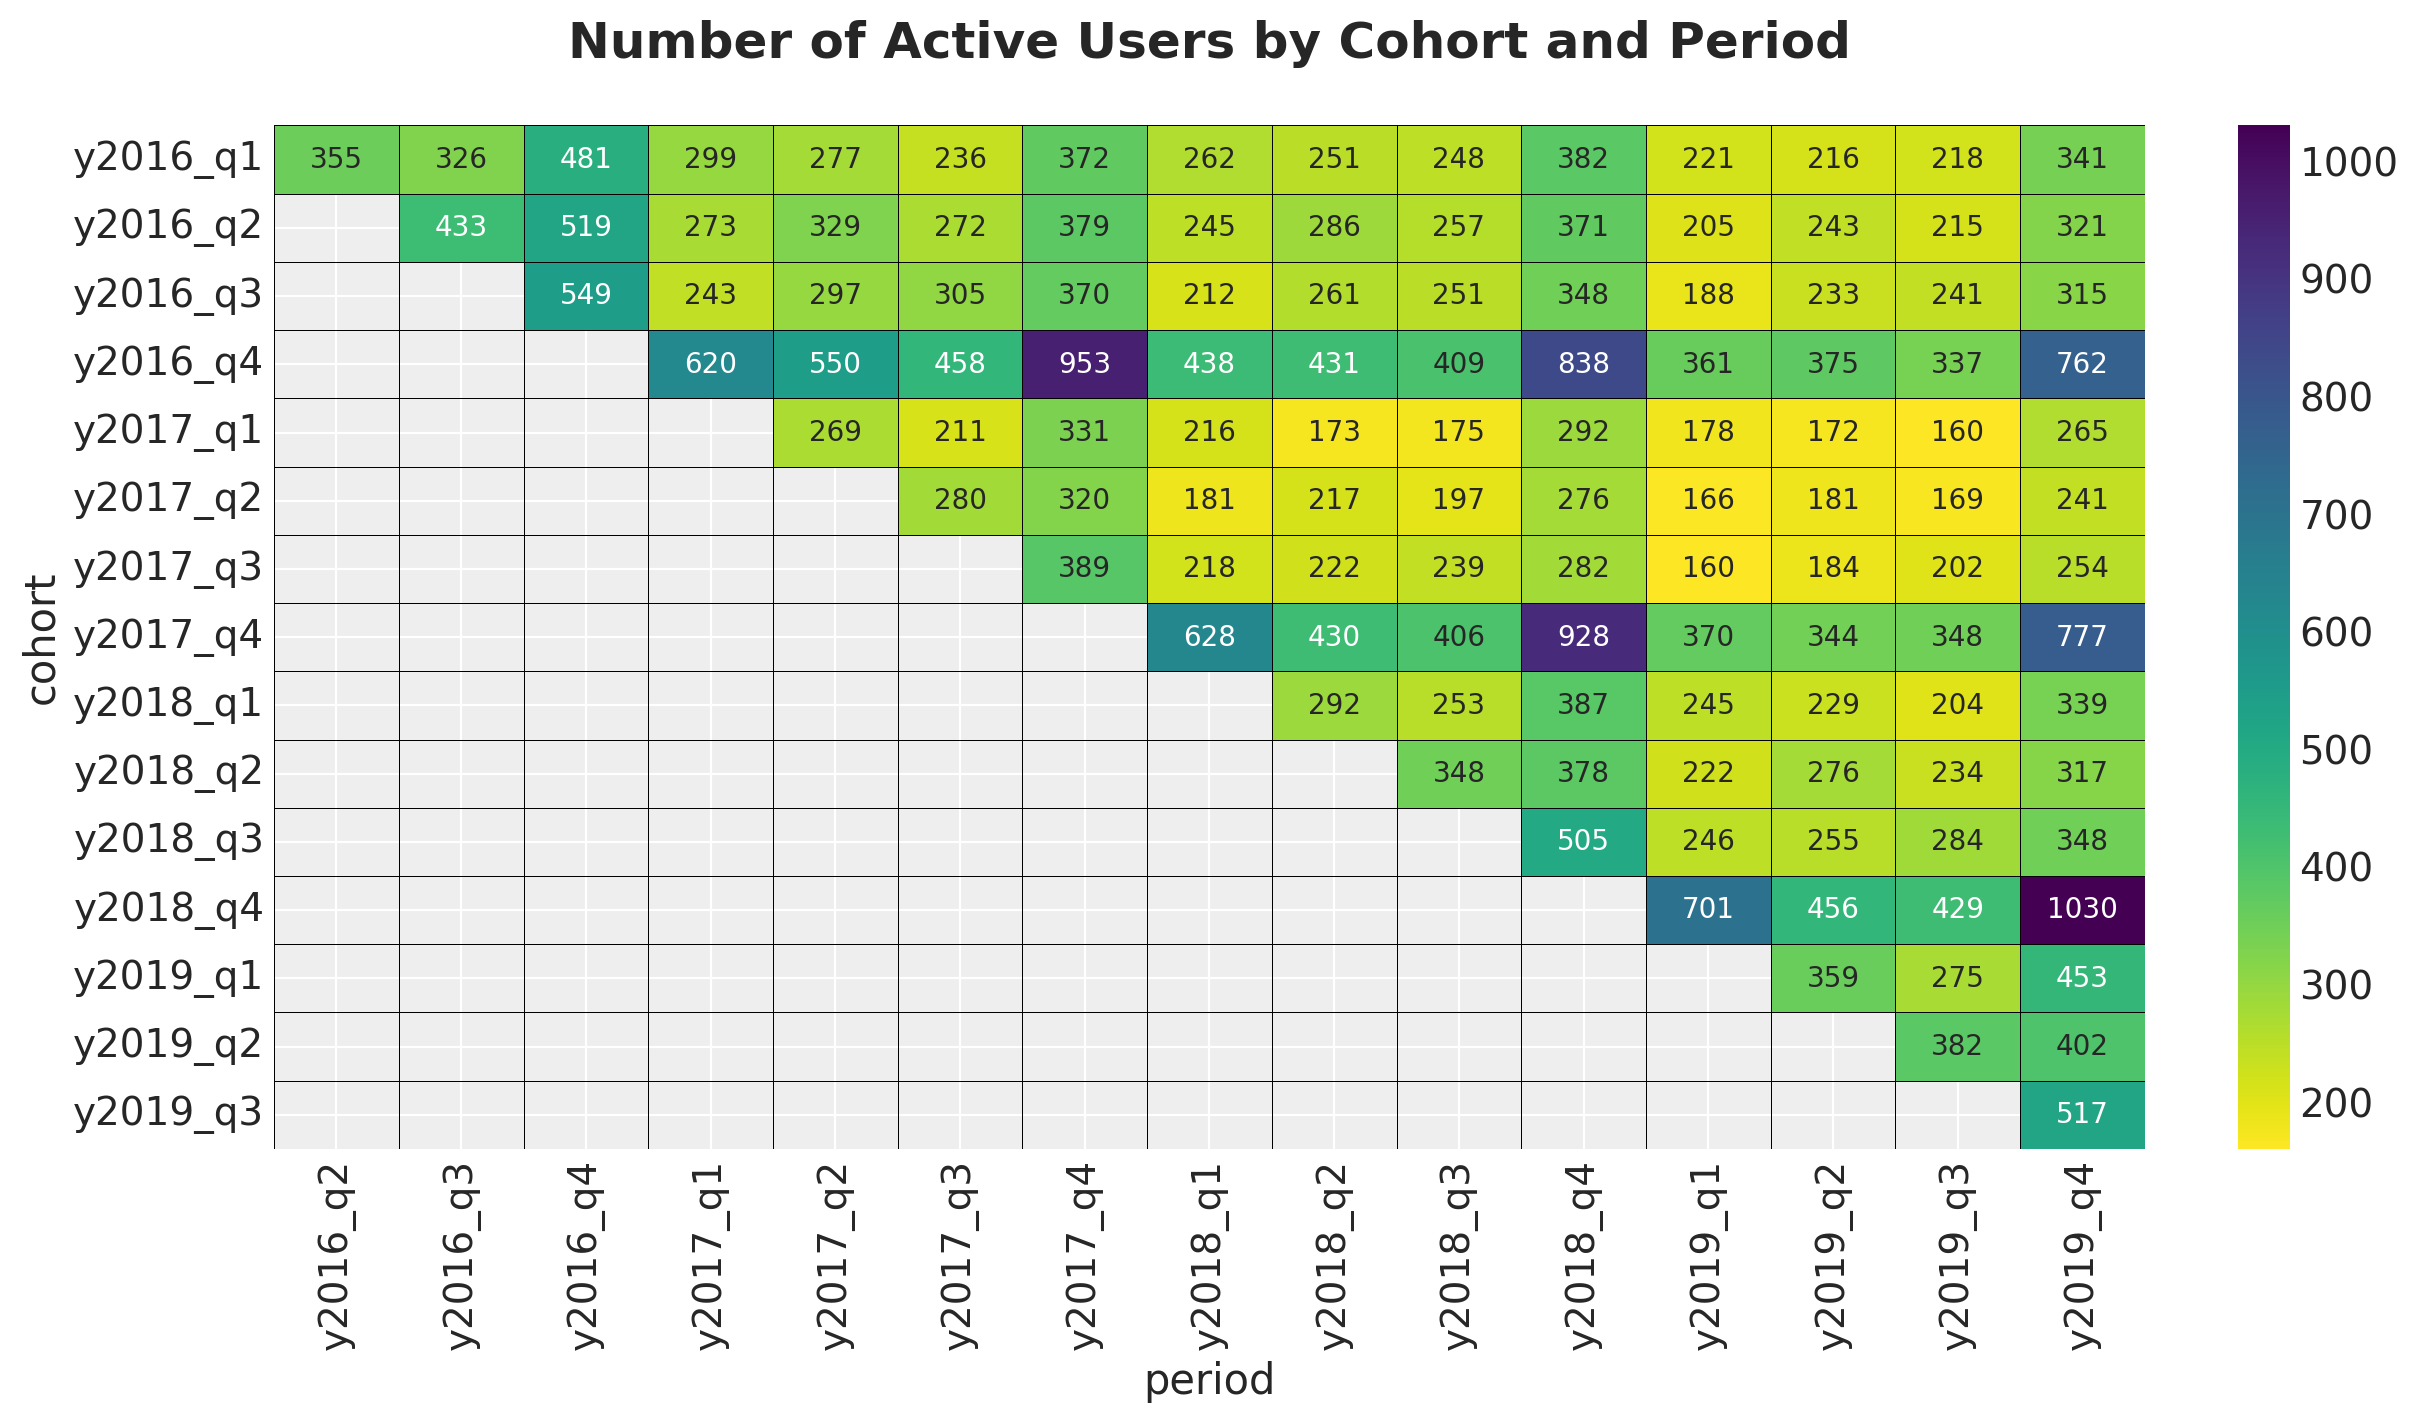

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))

(
    data_df.query("cohort_age != 0")
    .filter(["cohort", "period", "n_active_users"])
    .pivot_table(index="cohort", columns="period", values="n_active_users")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0f",
        ax=ax,
    )
)

ax.set_title(
    "Number of Active Users by Cohort and Period",
    fontsize=18,
    fontweight="bold",
    y=1.05,
);

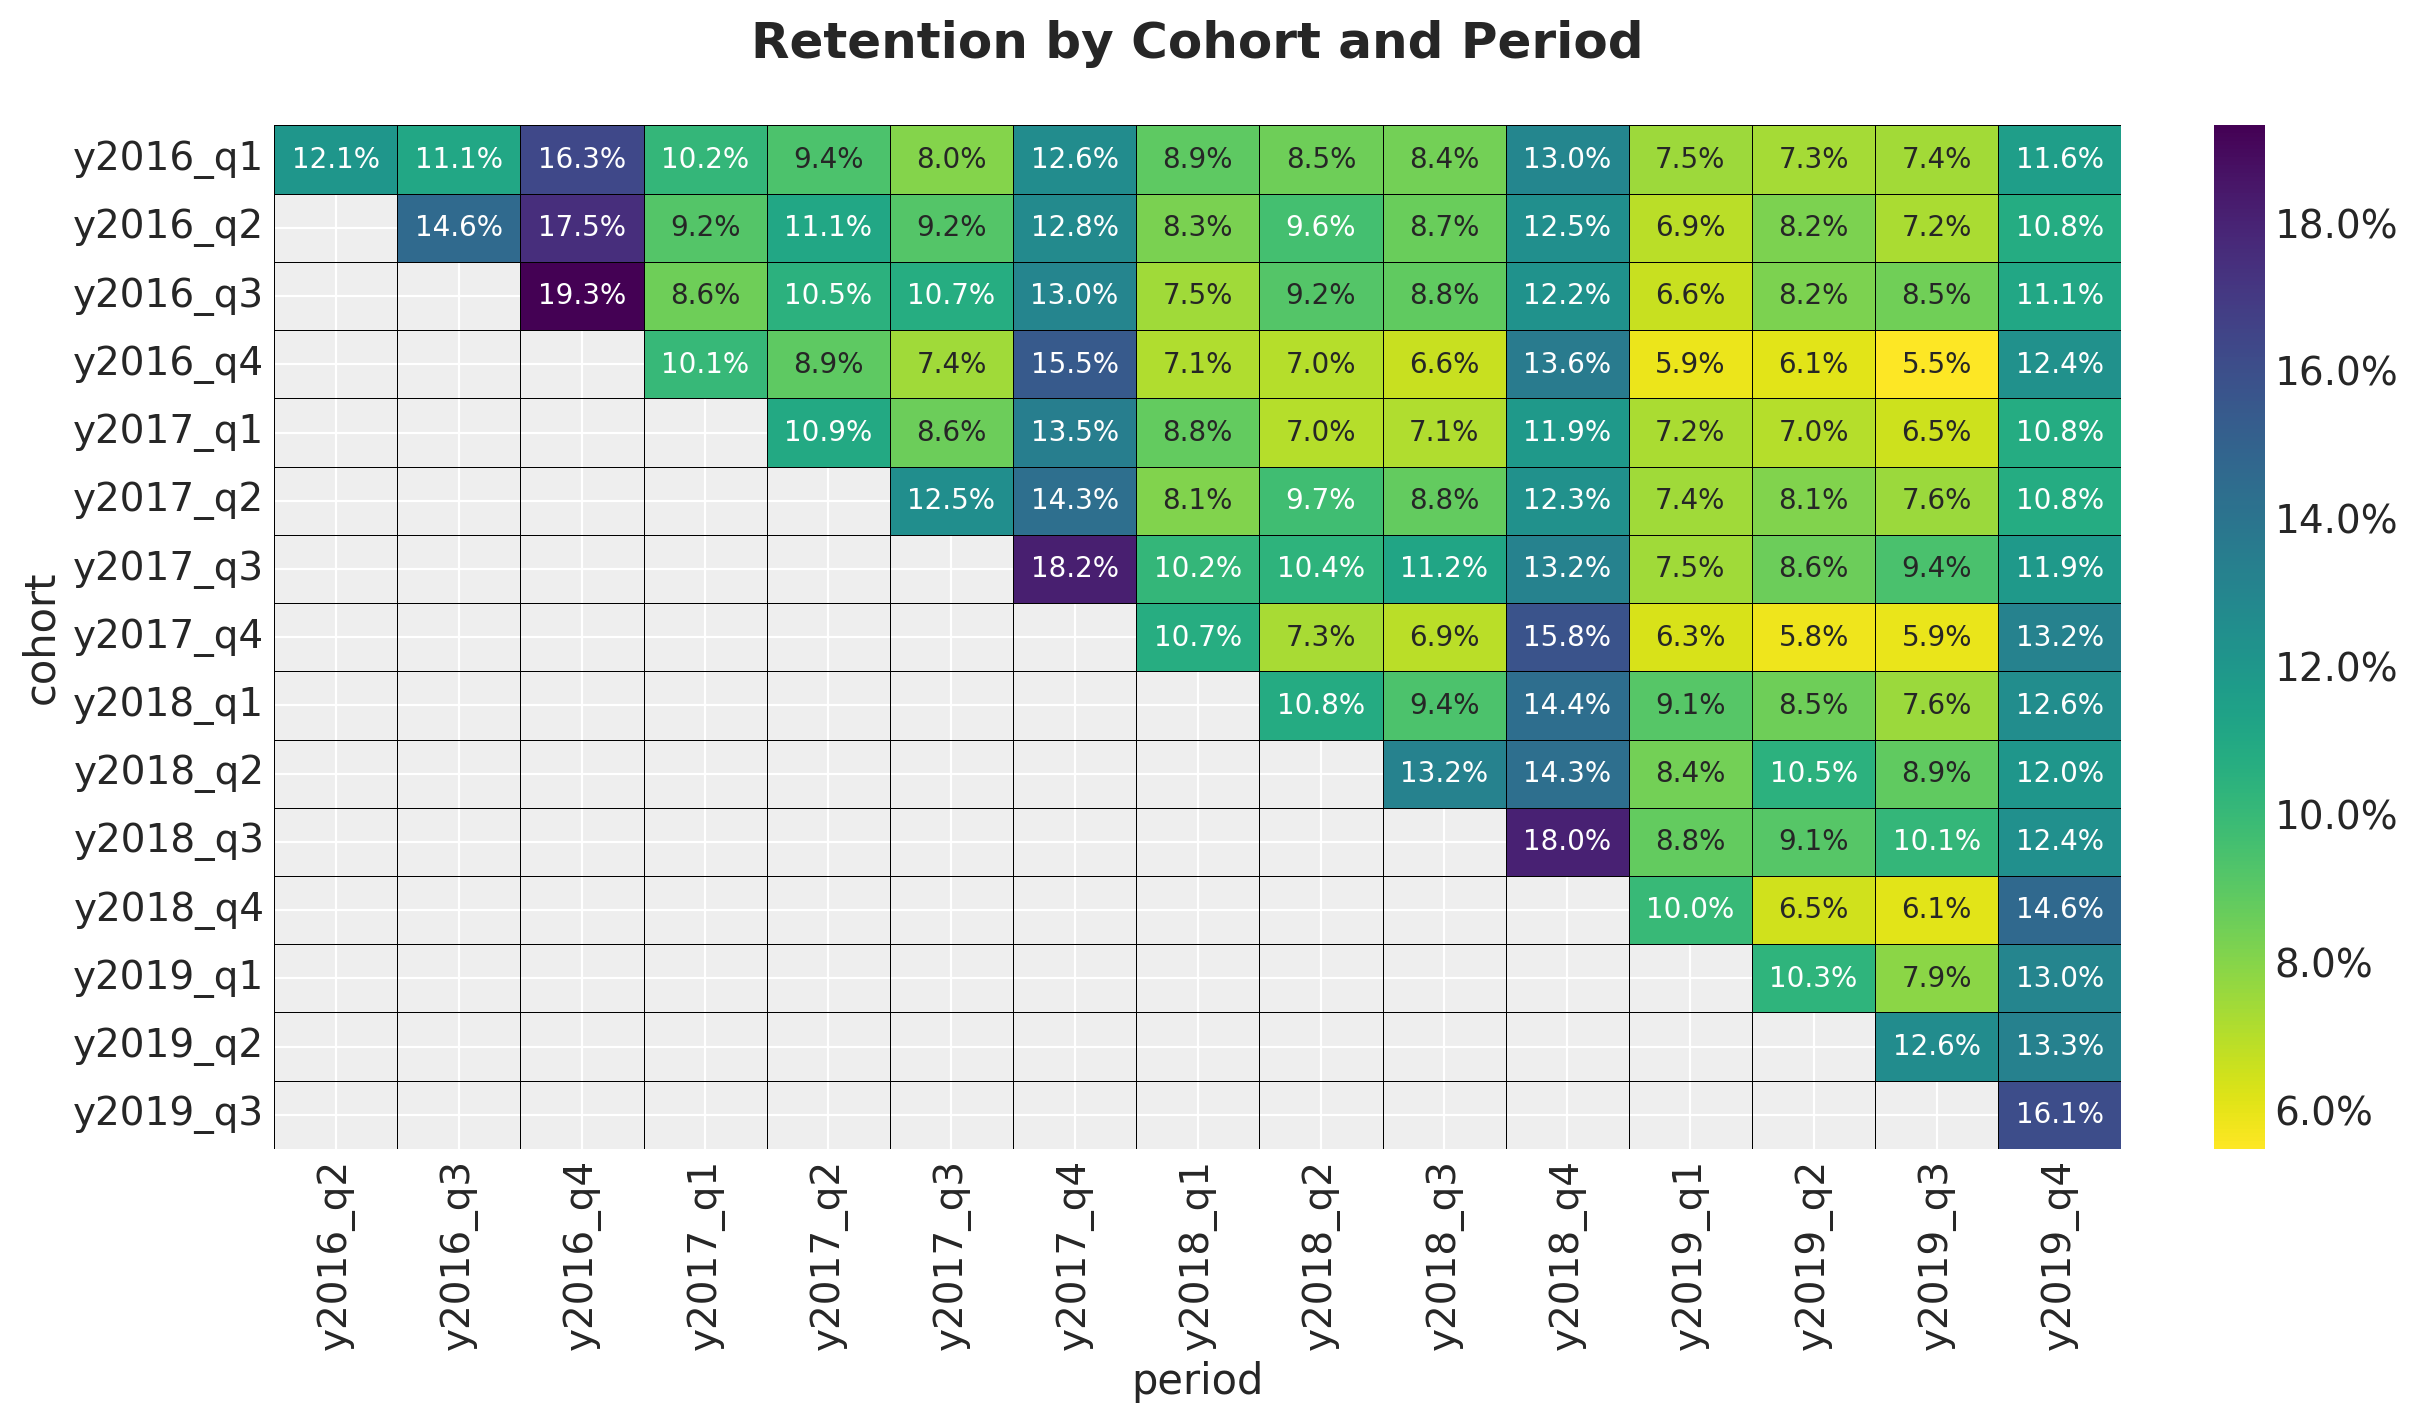

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))

(
    data_df.query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot_table(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.1%",
        cbar_kws={"format": mtick.PercentFormatter(1)},
        ax=ax,
    )
)

ax.set_title(
    "Retention by Cohort and Period",
    fontsize=18,
    fontweight="bold",
    y=1.05,
);

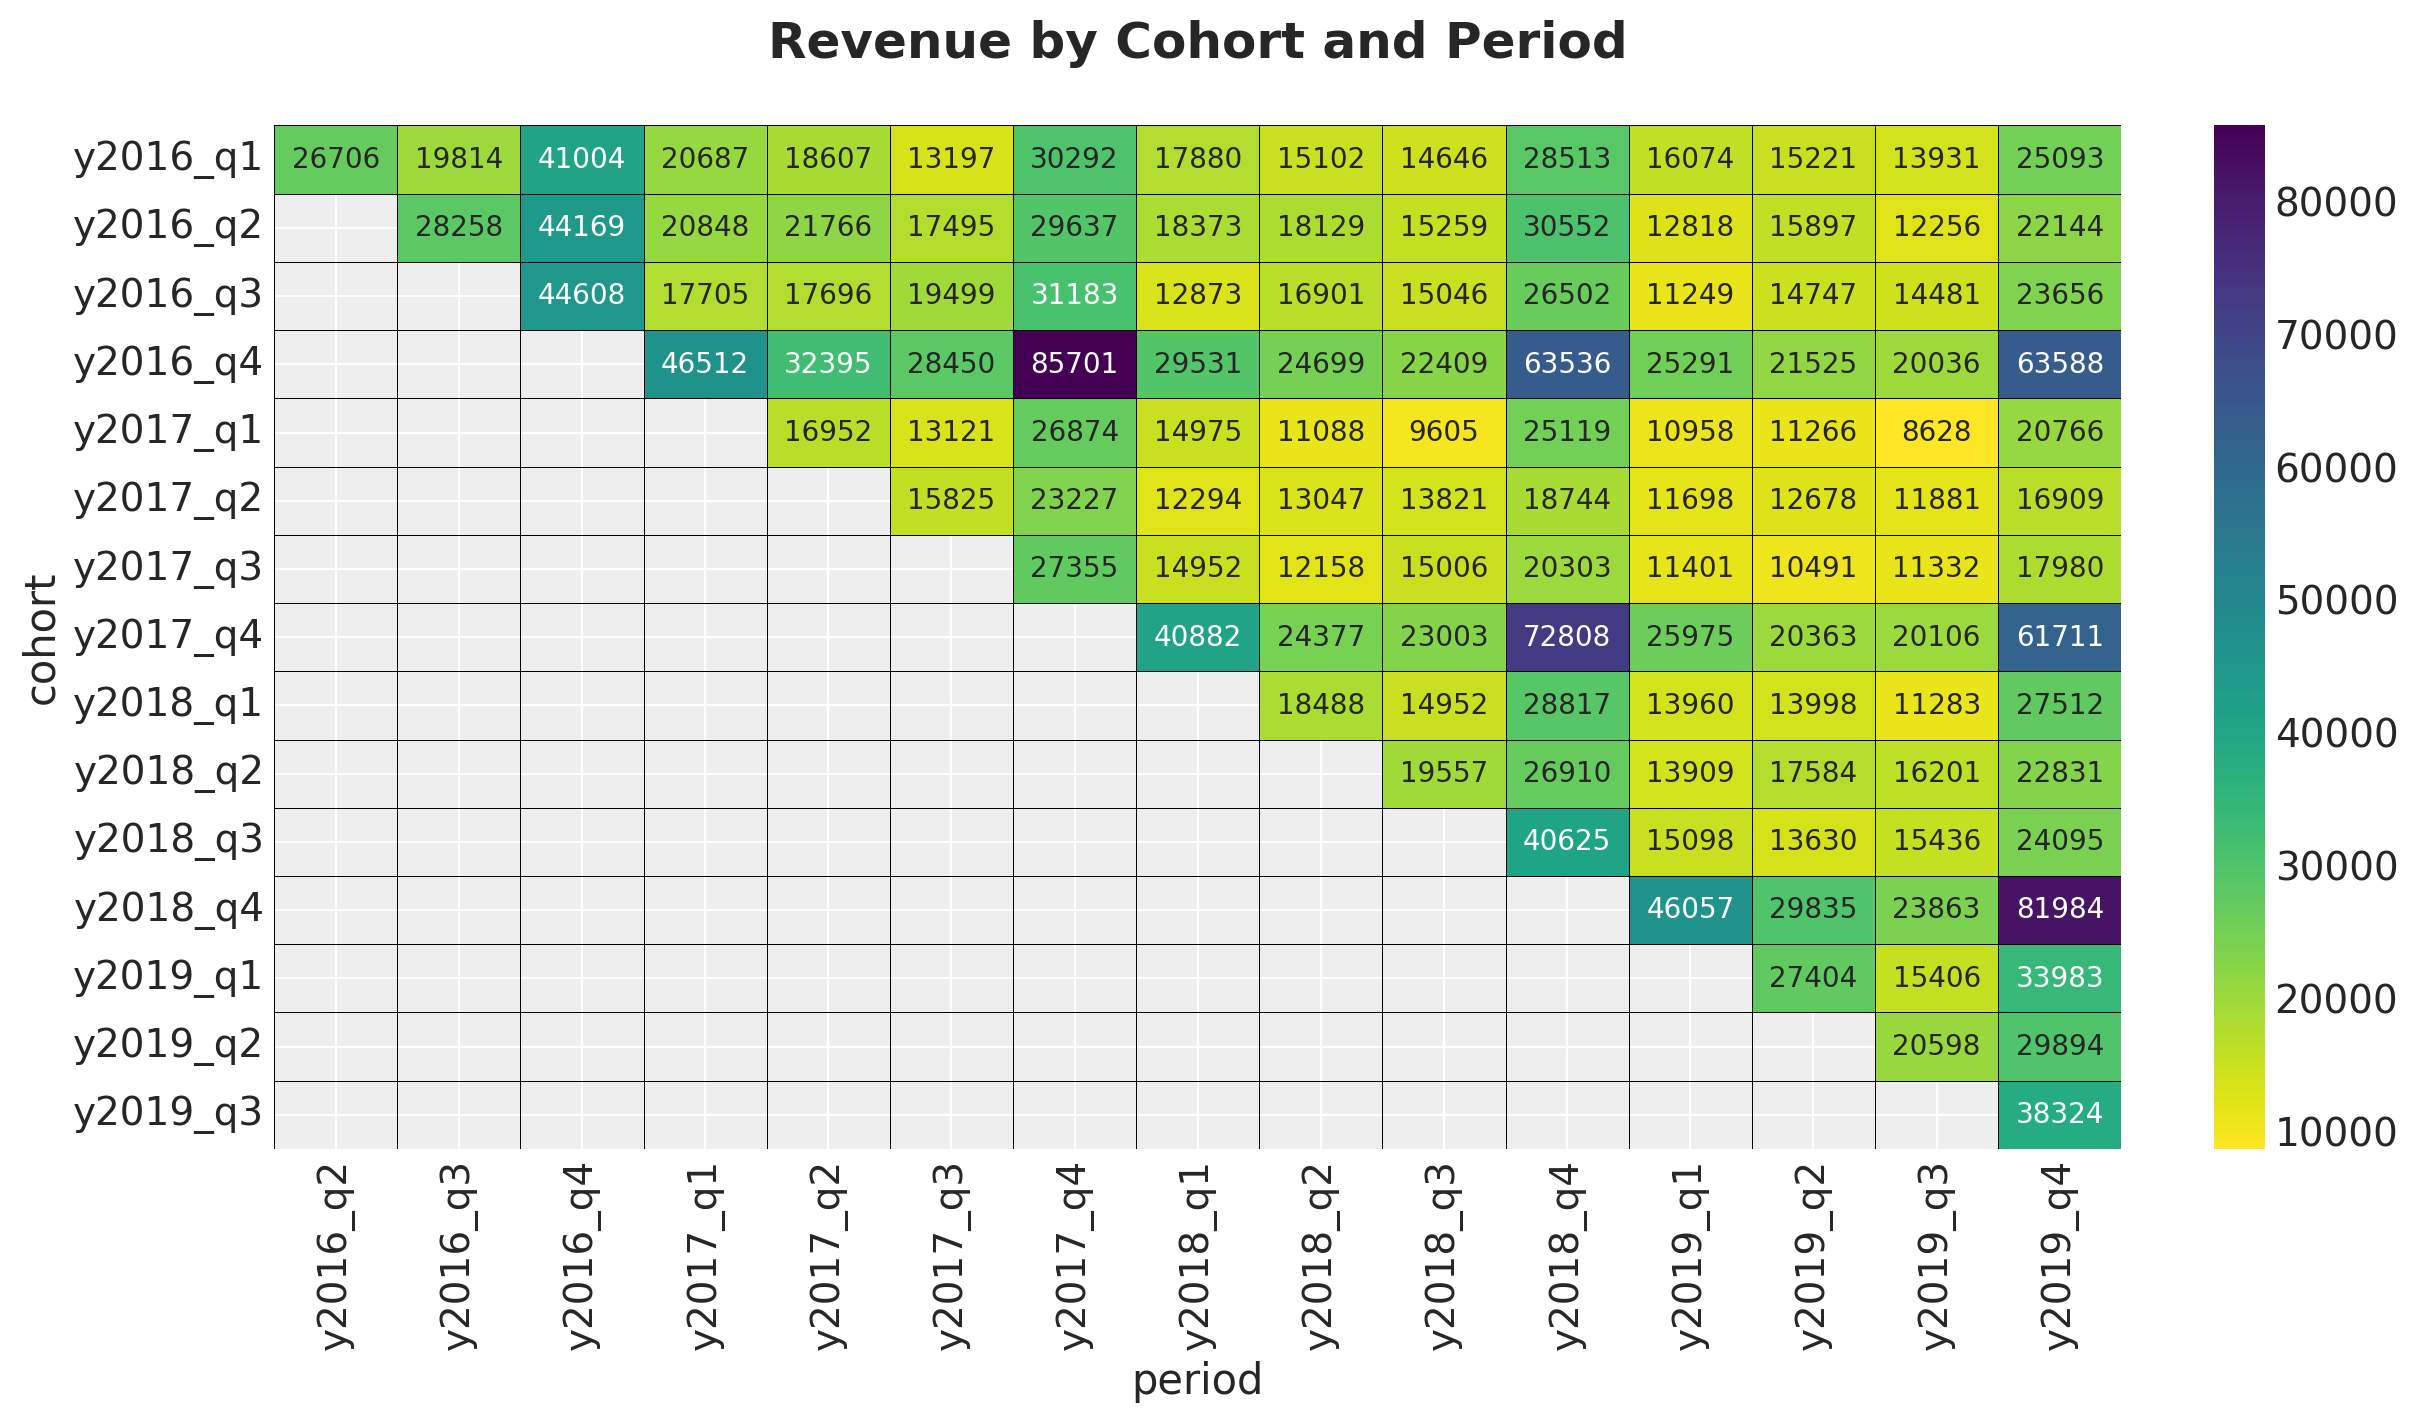

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))

(
    data_df.query("cohort_age != 0")
    .filter(["cohort", "period", "revenue"])
    .pivot_table(index="cohort", columns="period", values="revenue")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0f",
        ax=ax,
    )
)

ax.set_title(
    "Revenue by Cohort and Period",
    fontsize=18,
    fontweight="bold",
    y=1.05,
);

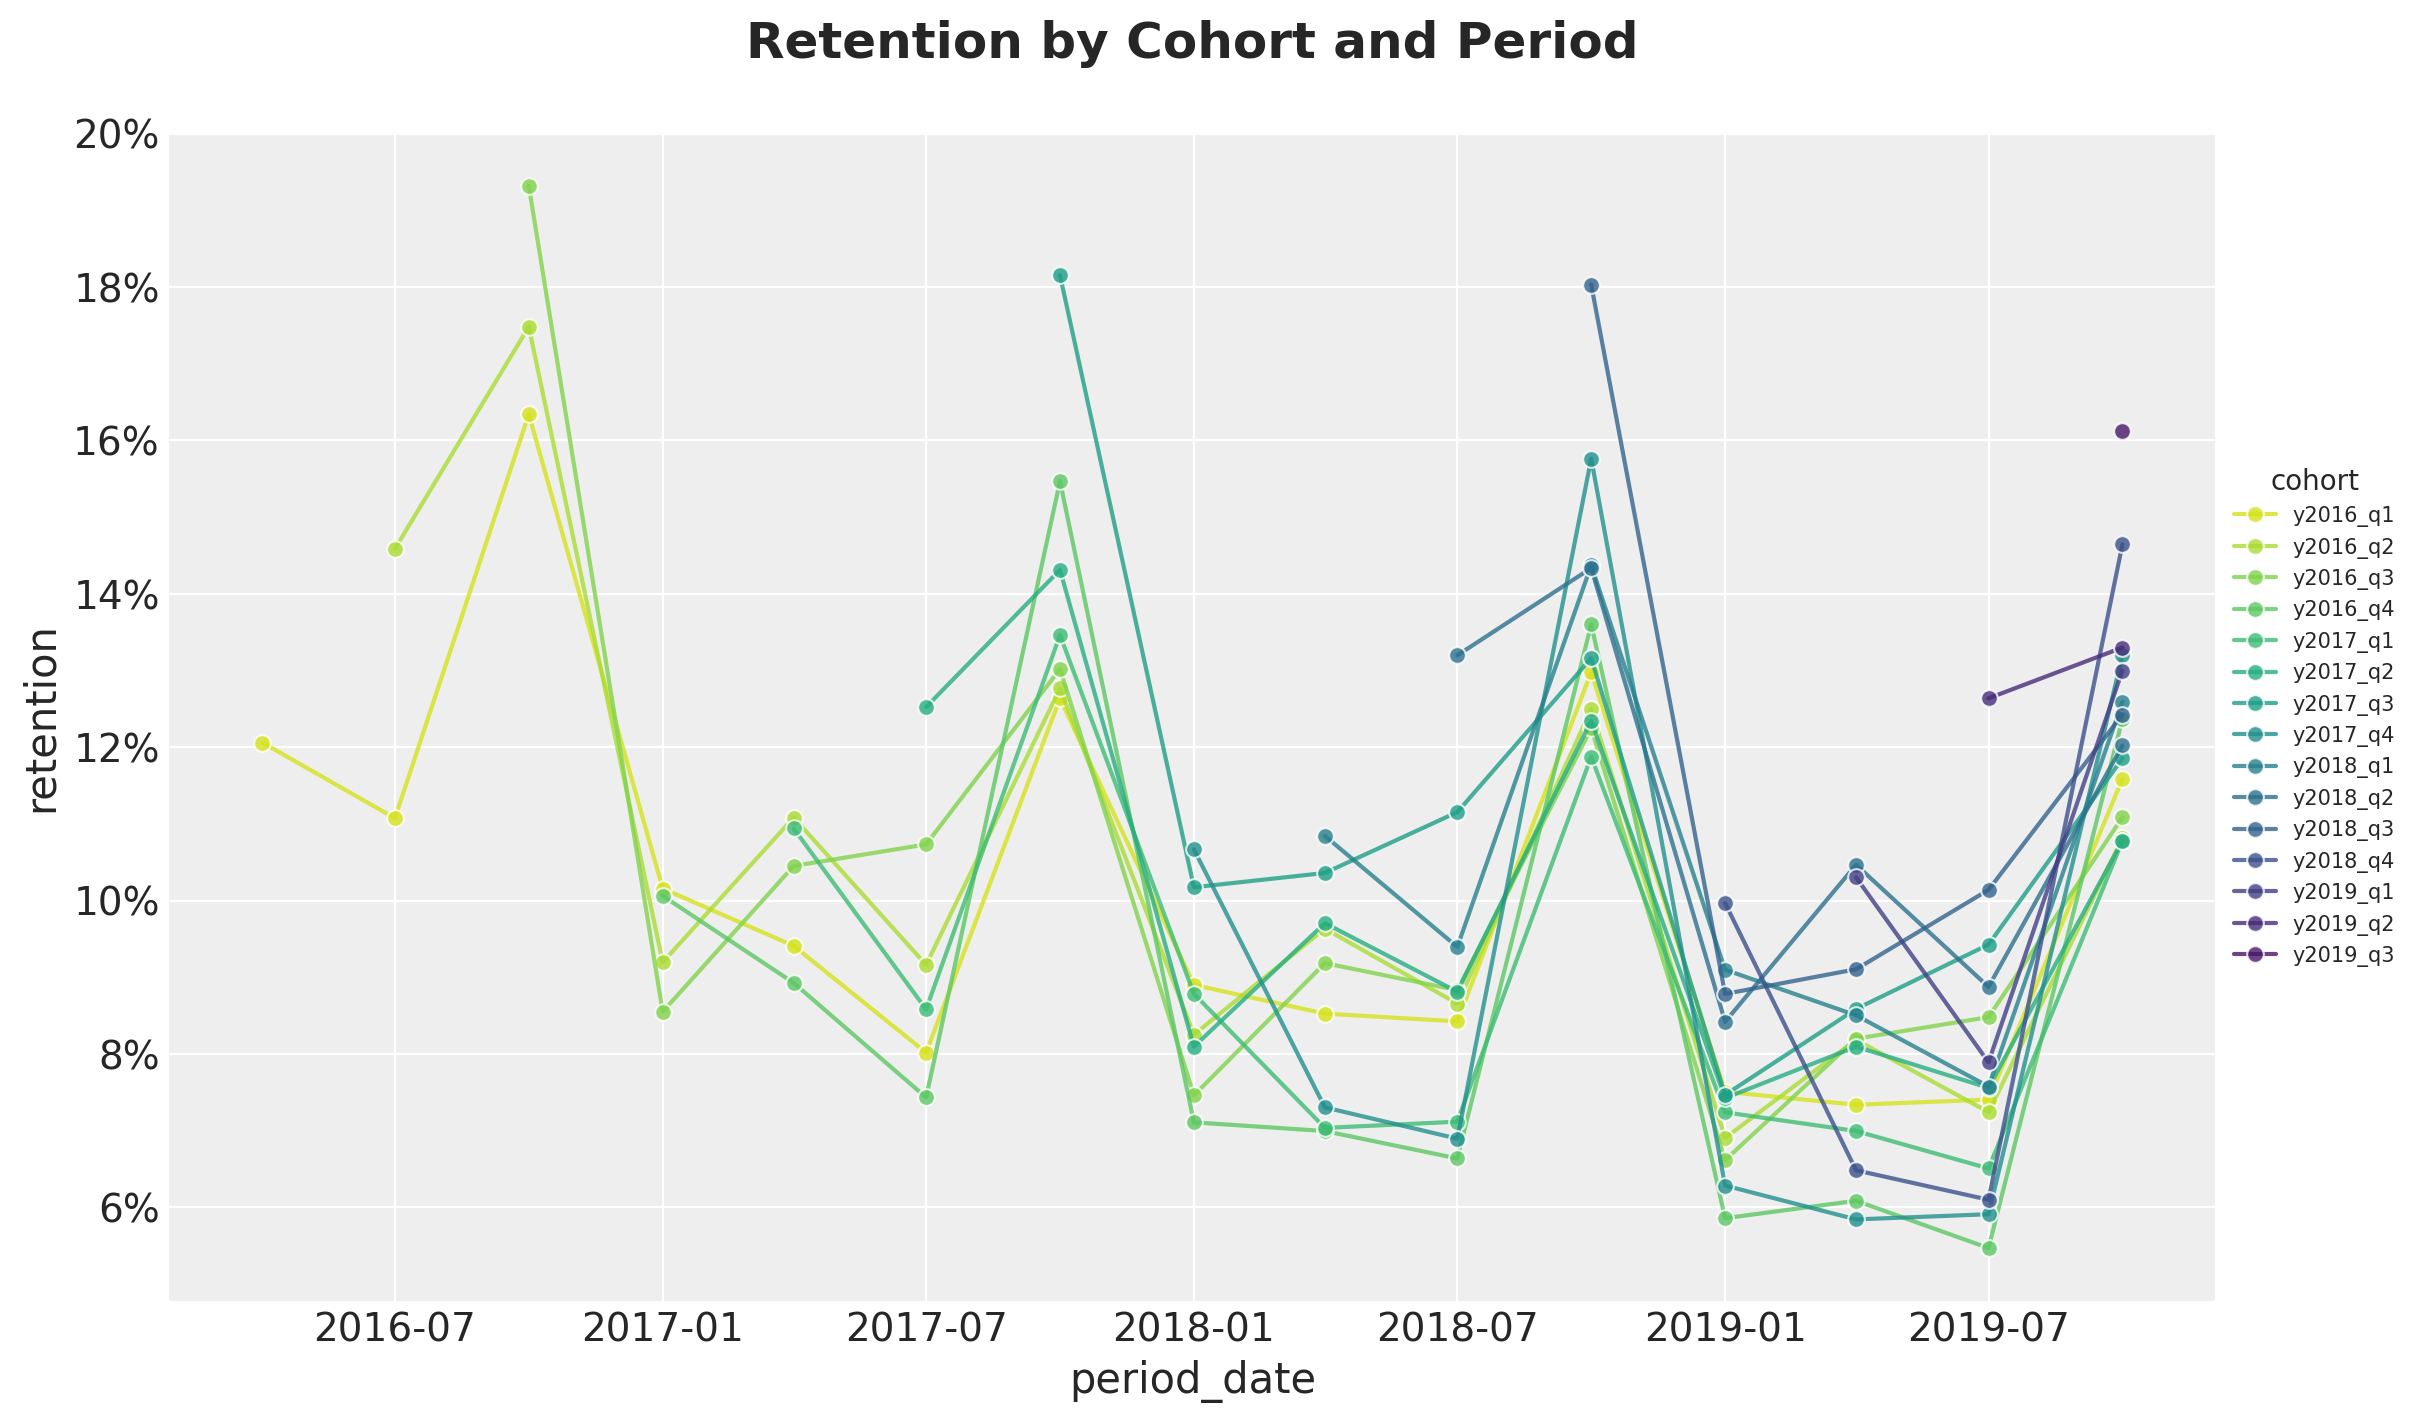

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="period_date",
    y="retention",
    marker="o",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=data_df.query("cohort_age > 0"),
    ax=ax,
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set_title("Retention by Cohort and Period", fontsize=18, fontweight="bold", y=1.05);

In [12]:
period_train_test_split = "y2019-q1"

train_data_df = data_df.query(f"period <= '{period_train_test_split}'")
test_data_df = data_df.query(f"period > '{period_train_test_split}'")

In [13]:
eps = np.finfo(float).eps
train_data_red_df = train_data_df.query("cohort_age > 0").reset_index(drop=True)
train_obs_idx = train_data_red_df.index.to_numpy()
train_n_users = train_data_red_df["n_users"].to_numpy()
train_n_active_users = train_data_red_df["n_active_users"].to_numpy()
train_retention = train_data_red_df["retention"].to_numpy()
train_retention_logit = logit(train_retention + eps)
train_revenue = train_data_red_df["revenue"].to_numpy() + eps
train_revenue_per_user = train_revenue / (train_n_active_users + eps)

train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()

features: list[str] = ["age", "cohort_age", "period_quarter"]
x_train = train_data_red_df[features]

train_age = train_data_red_df["age"].to_numpy()
train_age_scaler = MaxAbsScaler()
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()
train_cohort_age = train_data_red_df["cohort_age"].to_numpy()
train_cohort_age_scaler = MaxAbsScaler()
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(
    train_cohort_age.reshape(-1, 1)
).flatten()

In [14]:
data_df

,cohort,period,n_active_users,cohort_date,period_date,n_users,age,cohort_quarter,period_quarter,cohort_age,retention,revenue
0,y2016_q1,y2016_q1,2944,2016-01-01,2016-01-01,2944,1369,1,1,0,1.000000,183054.91
1,y2016_q1,y2016_q2,355,2016-01-01,2016-04-01,2944,1278,1,2,91,0.120584,26705.56
2,y2016_q1,y2016_q3,326,2016-01-01,2016-07-01,2944,1187,1,3,182,0.110734,19814.07
3,y2016_q1,y2016_q4,481,2016-01-01,2016-10-01,2944,1095,1,4,274,0.163383,41003.87
4,y2016_q1,y2017_q1,299,2016-01-01,2017-01-01,2944,1003,1,1,366,0.101562,20687.20
...,...,...,...,...,...,...,...,...,...,...,...,...
131,y2019_q2,y2019_q3,382,2019-04-01,2019-07-01,3023,92,2,3,91,0.126365,20597.87
132,y2019_q2,y2019_q4,402,2019-04-01,2019-10-01,3023,0,2,4,183,0.132980,29894.03
133,y2019_q3,y2019_q3,3208,2019-07-01,2019-07-01,3208,92,3,3,0,1.000000,178767.46
134,y2019_q3,y2019_q4,517,2019-07-01,2019-10-01,3208,0,3,4,92,0.161160,38323.64


In [15]:
train_n_active_users

array([355, 326, 481, 299, 277, 236, 372, 262, 251, 248, 382, 433, 519,
       273, 329, 272, 379, 245, 286, 257, 371, 549, 243, 297, 305, 370,
       212, 261, 251, 348, 620, 550, 458, 953, 438, 431, 409, 838, 269,
       211, 331, 216, 173, 175, 292, 280, 320, 181, 217, 197, 276, 389,
       218, 222, 239, 282, 628, 430, 406, 928, 292, 253, 387, 348, 378,
       505])

/Users/juanitorduz/Documents/envs/pymc-marketing-env/lib/python3.12/site-packages/pymc_bart/bart.py:141: UserWarning: Options linear and mix are experimental and still not well tested
Use with caution.
  warnings.warn(


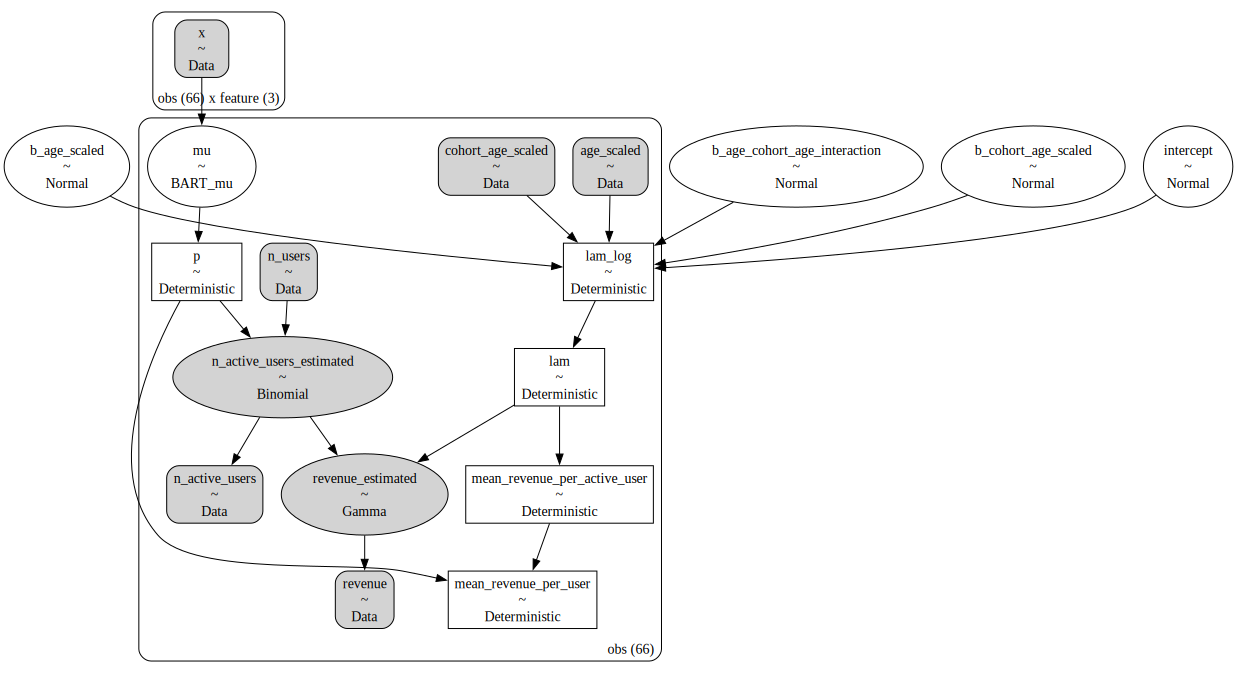

In [16]:
with pm.Model(coords={"feature": features}) as model:
    # --- Data ---
    model.add_coord(name="obs", values=train_obs_idx)
    age_scaled = pm.Data(name="age_scaled", value=train_age_scaled, dims="obs")
    cohort_age_scaled = pm.Data(
        name="cohort_age_scaled", value=train_cohort_age_scaled, dims="obs"
    )
    x = pm.Data(name="x", value=x_train, dims=("obs", "feature"))
    n_users = pm.Data(name="n_users", value=train_n_users, dims="obs")
    n_active_users = pm.Data(
        name="n_active_users", value=train_n_active_users, dims="obs"
    )
    revenue = pm.Data(name="revenue", value=train_revenue, dims="obs")

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_age_scaled = pm.Normal(name="b_age_scaled", mu=0, sigma=1)
    b_cohort_age_scaled = pm.Normal(name="b_cohort_age_scaled", mu=0, sigma=1)
    b_age_cohort_age_interaction = pm.Normal(
        name="b_age_cohort_age_interaction", mu=0, sigma=1
    )

    # --- Parametrization ---
    # The BART component models the image of the retention rate under the
    # logit transform so that the range is not constrained to [0, 1].
    mu = pmb.BART(
        name="mu",
        X=x,
        Y=train_retention_logit,
        m=100,
        response="mix",
        split_rules=[ContinuousSplitRule(), ContinuousSplitRule(), SubsetSplitRule()],
        dims="obs",
    )
    # We use the inverse logit transform to get the retention rate back into [0, 1].
    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="obs")
    # We add a small epsilon to avoid numerical issues.
    p = pt.switch(pt.eq(p, 0), eps, p)
    p = pt.switch(pt.eq(p, 1), 1 - eps, p)

    # For the revenue component we use a Gamma distribution where we combine the number
    # of estimated active users with the average revenue per user.
    lam_log = pm.Deterministic(
        name="lam_log",
        var=intercept
        + b_age_scaled * age_scaled
        + b_cohort_age_scaled * cohort_age_scaled
        + b_age_cohort_age_interaction * age_scaled * cohort_age_scaled,
        dims="obs",
    )

    lam = pm.Deterministic(name="lam", var=pm.math.exp(lam_log), dims="obs")

    # --- Likelihood ---
    n_active_users_estimated = pm.Binomial(
        name="n_active_users_estimated",
        n=n_users,
        p=p,
        observed=n_active_users,
        dims="obs",
    )

    x = pm.Gamma(
        name="revenue_estimated",
        alpha=n_active_users_estimated + eps,
        beta=lam,
        observed=revenue,
        dims="obs",
    )

    mean_revenue_per_active_user = pm.Deterministic(
        name="mean_revenue_per_active_user", var=(1 / lam), dims="obs"
    )
    pm.Deterministic(
        name="mean_revenue_per_user", var=p * mean_revenue_per_active_user, dims="obs"
    )

pm.model_to_graphviz(model=model)

In [17]:
with model:
    idata = pm.sample(draws=2_000, chains=4, random_seed=rng)
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=rng))


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

In [21]:
assert idata.sample_stats["diverging"].sum().item() == 0

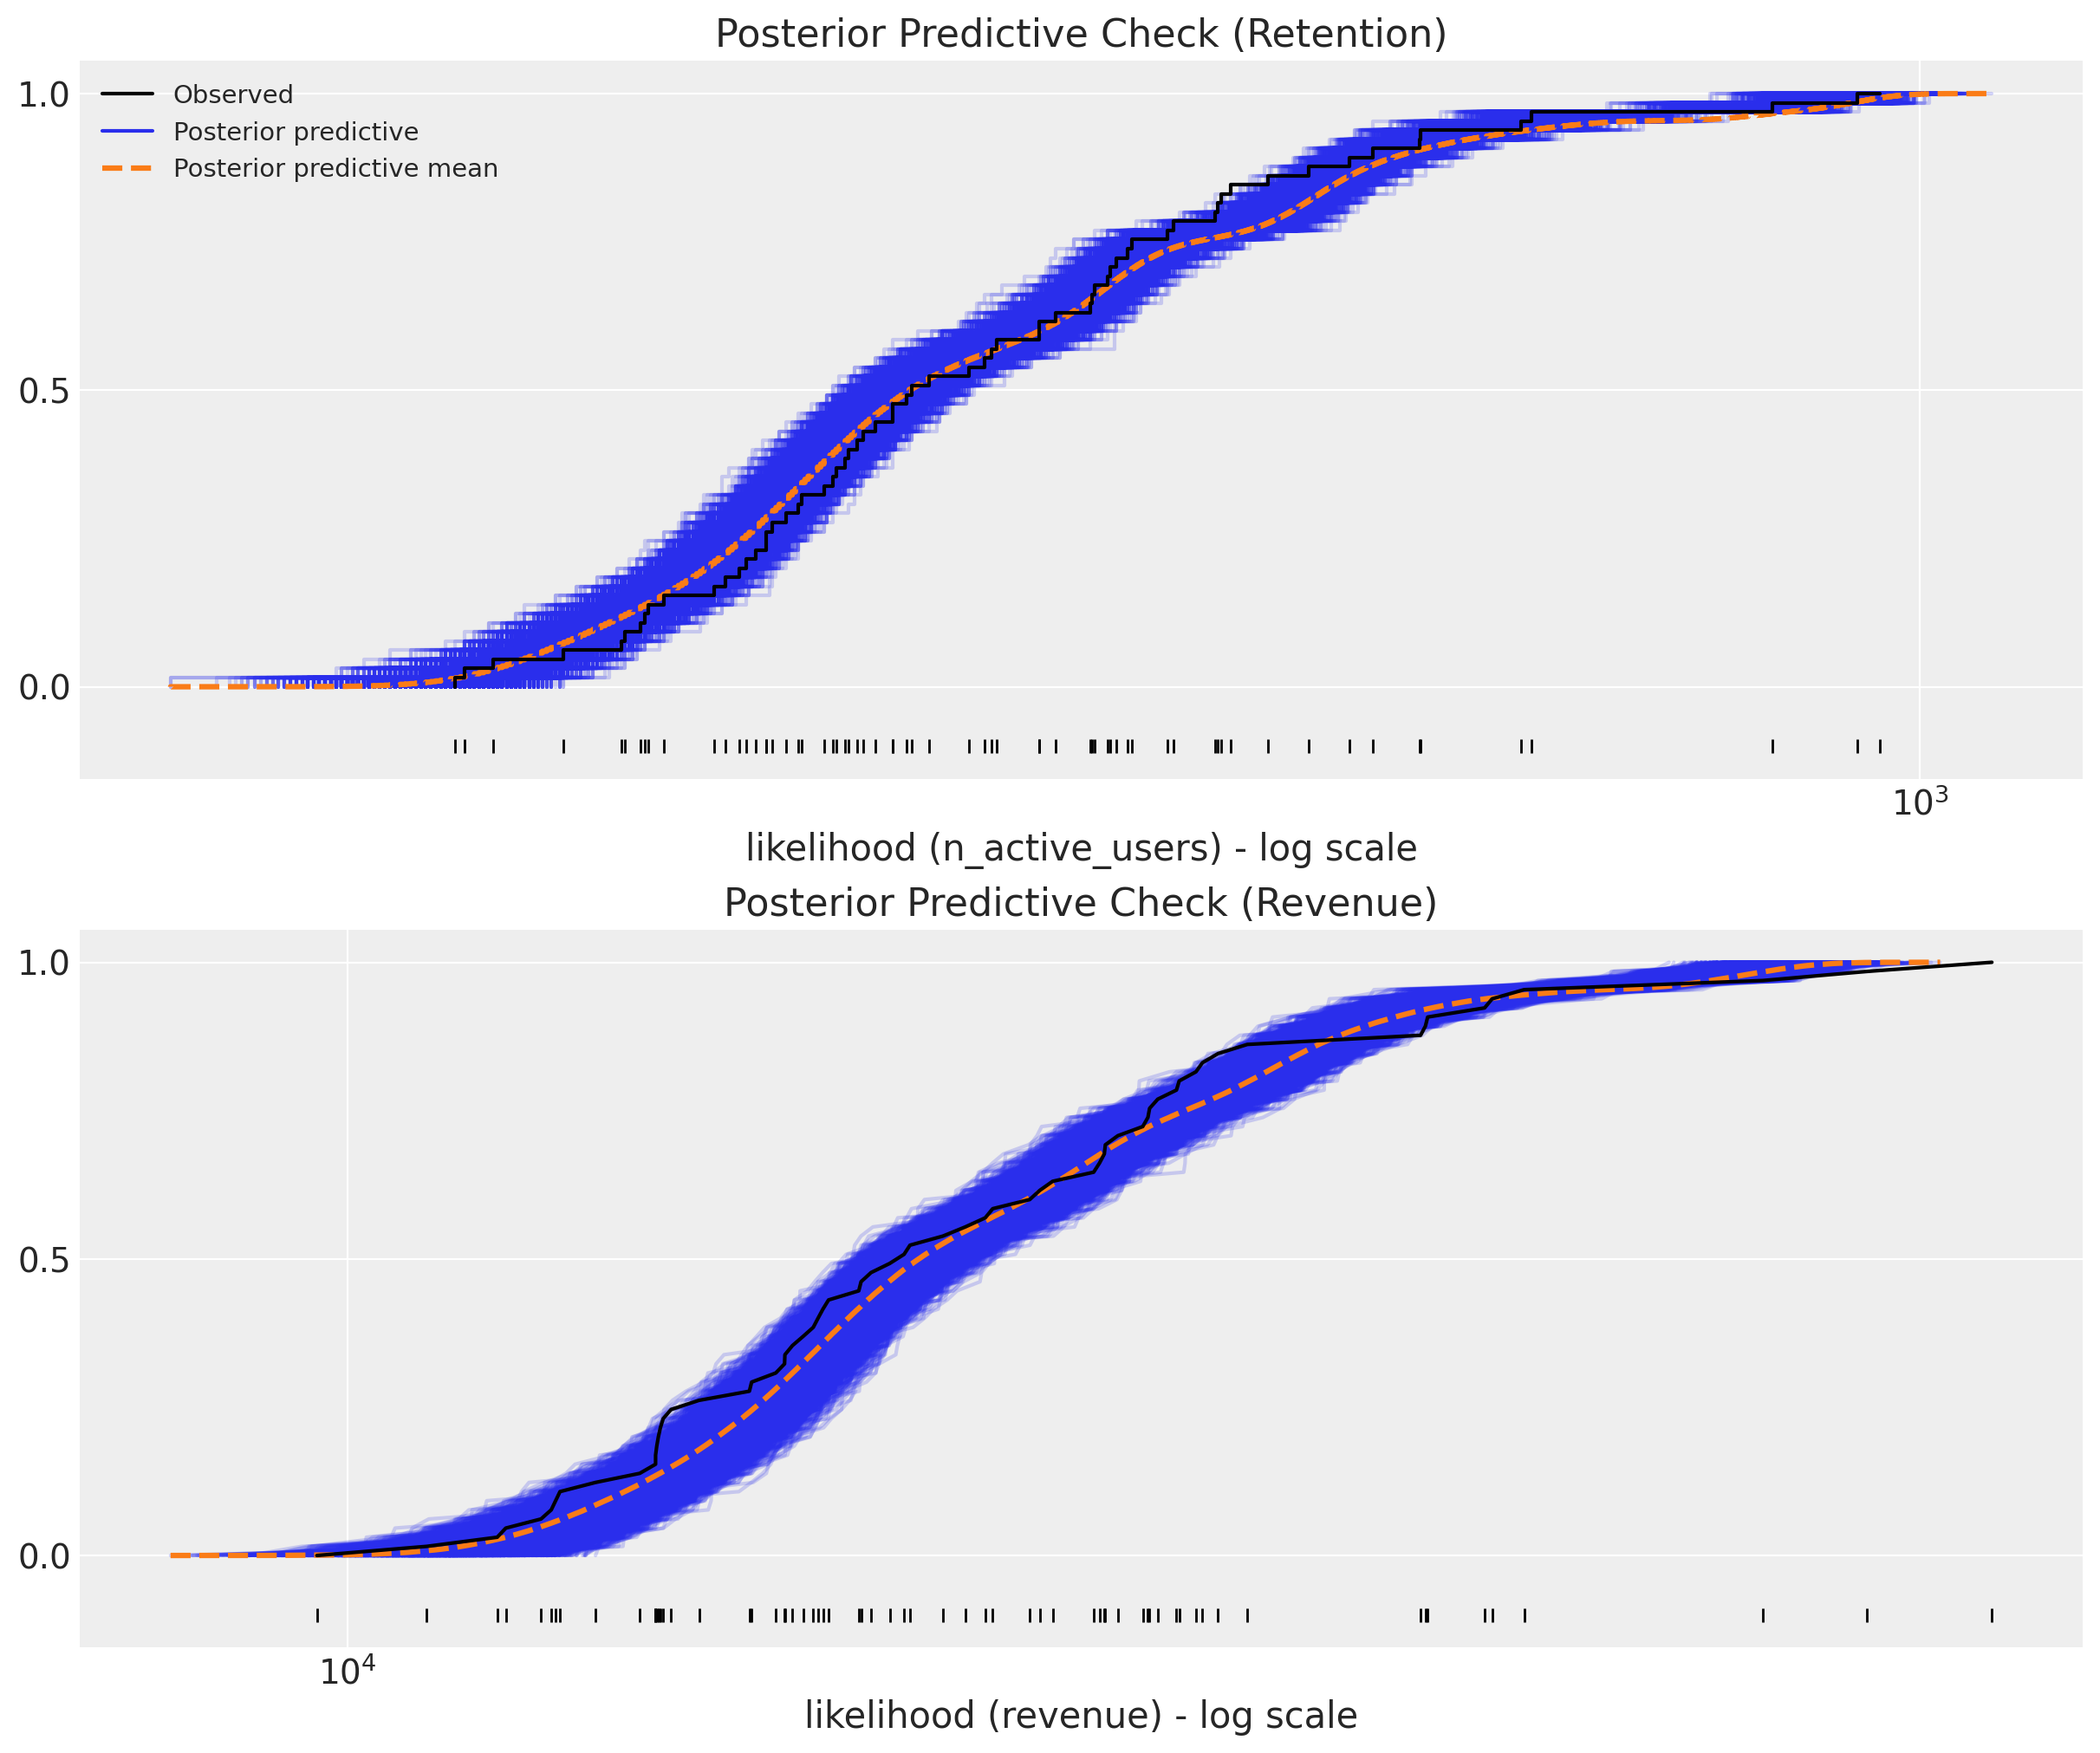

In [22]:
ax = az.plot_ppc(
    data=idata,
    kind="cumulative",
    observed_rug=True,
    grid=(2, 1),
    figsize=(12, 10),
    random_seed=seed,
)
ax[0].set(
    title="Posterior Predictive Check (Retention)",
    xscale="log",
    xlabel="likelihood (n_active_users) - log scale",
)
ax[1].set(
    title="Posterior Predictive Check (Revenue)",
    xscale="log",
    xlabel="likelihood (revenue) - log scale",
);

Text(0.5, 0.98, 'Model Trace')

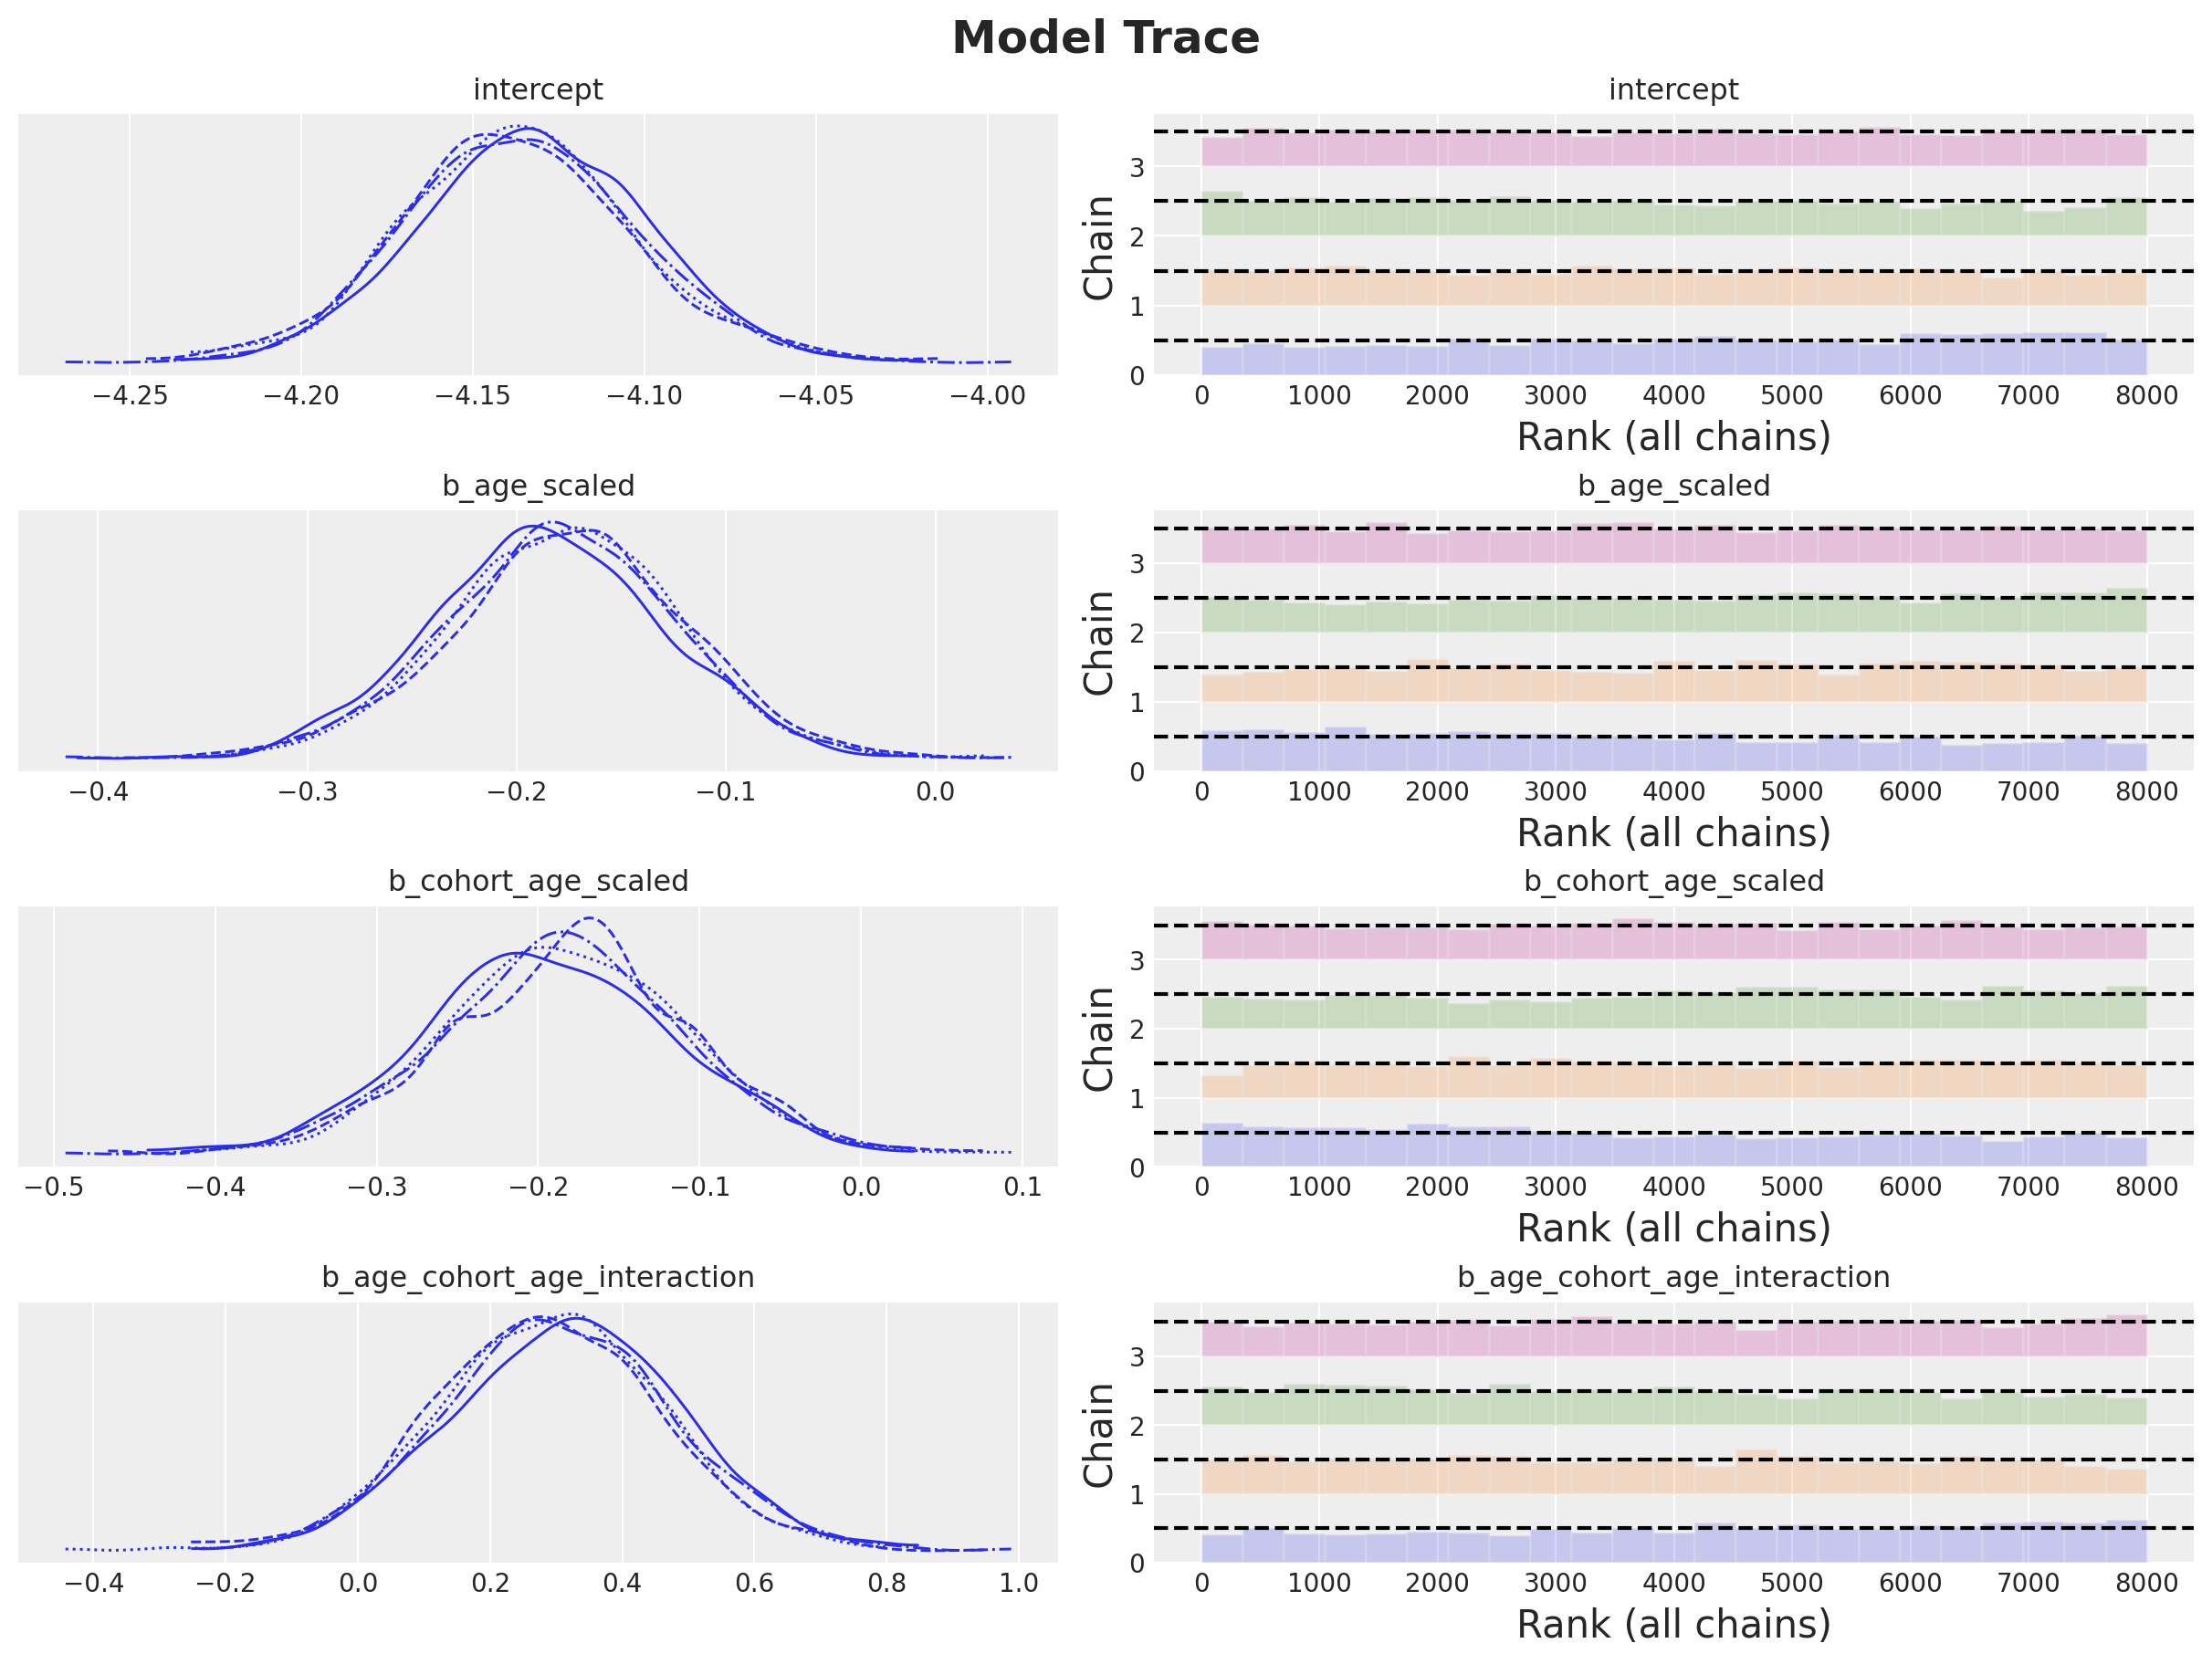

In [24]:
_ = az.plot_trace(
    data=idata,
    var_names=[
        "intercept",
        "b_age_scaled",
        "b_cohort_age_scaled",
        "b_age_cohort_age_interaction",
    ],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold")